In [1]:
from mfe.feature import rank_estimate, nmf
from mfe.from_txt import msi_from_txt, get_ref_peaks, create_feature_table
from mfe.peak_picking import get_peak_ranks, sel_peak_by_rank

First import the txt file exported from DA and convert it to a dictionary for the convenience of later process

In [2]:
raw_txt_path = r'./SBB5-10cm_mz520-580.txt'

spectra = msi_from_txt(raw_txt_path)

100%|██████████| 9554/9554 [00:45<00:00, 209.35it/s]


Secondly, get a list of reference peaks that will be used to align all spectra

In [3]:
ref = get_ref_peaks(spectra)

100%|██████████| 59/59 [00:00<00:00, 25179.48it/s]


Align all spectra onto the reference peaks that were identified in the last step

In [4]:
feature_table = create_feature_table(spectra, ref)

Binning the spectrum...


100%|██████████| 9554/9554 [01:46<00:00, 90.05it/s] 


Combining the binned spectrum...


100%|██████████| 9554/9554 [00:57<00:00, 167.56it/s]


Here is the head 5 rows of the resulted feature table. The table is organized in such a way, that each row actually represents one spectrum from a single spot, and each column represent one ion image. The last two columns are the x, y coordinates of the corresponding spot in the same row. The cell values are the peak intensity from the txt file, without any normalization.

In [5]:
feature_table.head(5)

,520.1209,520.1564,520.4478,521.1287,521.1652,521.3082,521.4006,521.4888,522.1501,522.1651,...,577.5005,578.0059,578.2048,578.2328,578.2693,578.2898,578.3317,578.5123,x,y
0,0.0,0.0,0.0,376508.56250,464671.43750,0.000,0.0,0.0,0.000000e+00,0.000000e+00,...,946728.00000,0.00,0.000,1119742.625,3.915314e+05,5.893009e+05,1081267.25,1082685.875,68,36
1,0.0,0.0,0.0,444811.09375,479681.28125,0.000,0.0,0.0,8.673442e+05,1.273734e+06,...,0.00000,0.00,0.000,631501.000,7.000848e+05,0.000000e+00,0.00,2156473.250,74,36
2,0.0,0.0,0.0,0.00000,0.00000,0.000,0.0,0.0,1.437006e+06,1.631815e+06,...,0.00000,709144.75,1071749.375,1694064.375,1.158546e+06,0.000000e+00,0.00,2104168.500,114,36
3,0.0,0.0,0.0,0.00000,0.00000,1008383.875,0.0,0.0,0.000000e+00,5.496841e+05,...,387001.12500,716455.75,1232450.750,0.000,0.000000e+00,2.112408e+06,0.00,1268816.250,55,34
4,0.0,0.0,0.0,0.00000,0.00000,0.000,0.0,0.0,4.389075e+05,0.000000e+00,...,415738.53125,818168.50,0.000,1198714.250,4.515864e+05,4.531606e+05,0.00,2201242.000,77,36


Then we rank all ion images based on their structure scores

In [6]:
t_df, ims = get_peak_ranks(feature_table)

100%|██████████| 776/776 [00:16<00:00, 47.74it/s]


Take a look at the top 5 ion images as an example what's picked in this step

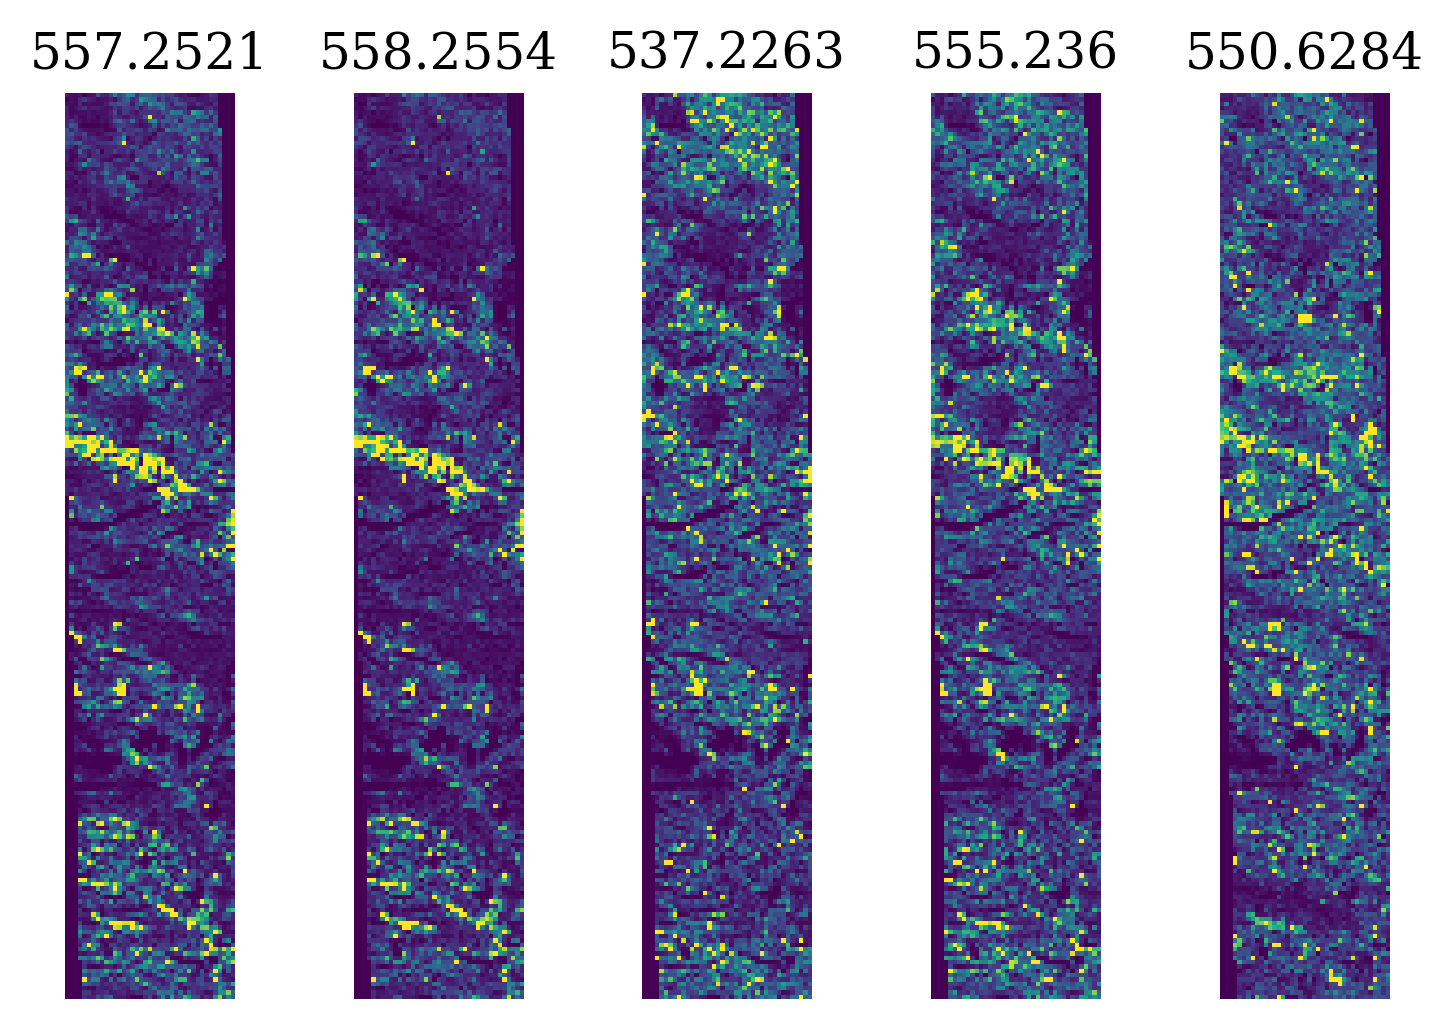

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5)
ax_idx = 0
for i in list(t_df.values.argsort(0)[-1:-6:-1].flatten()):
    ax[ax_idx].imshow(ims[i])
    ax[ax_idx].set_title(list(t_df.index)[i])
    ax[ax_idx].axis('off')
    ax_idx += 1
plt.show()

Then the bottom 5 ion images as an example what's dropped in this step

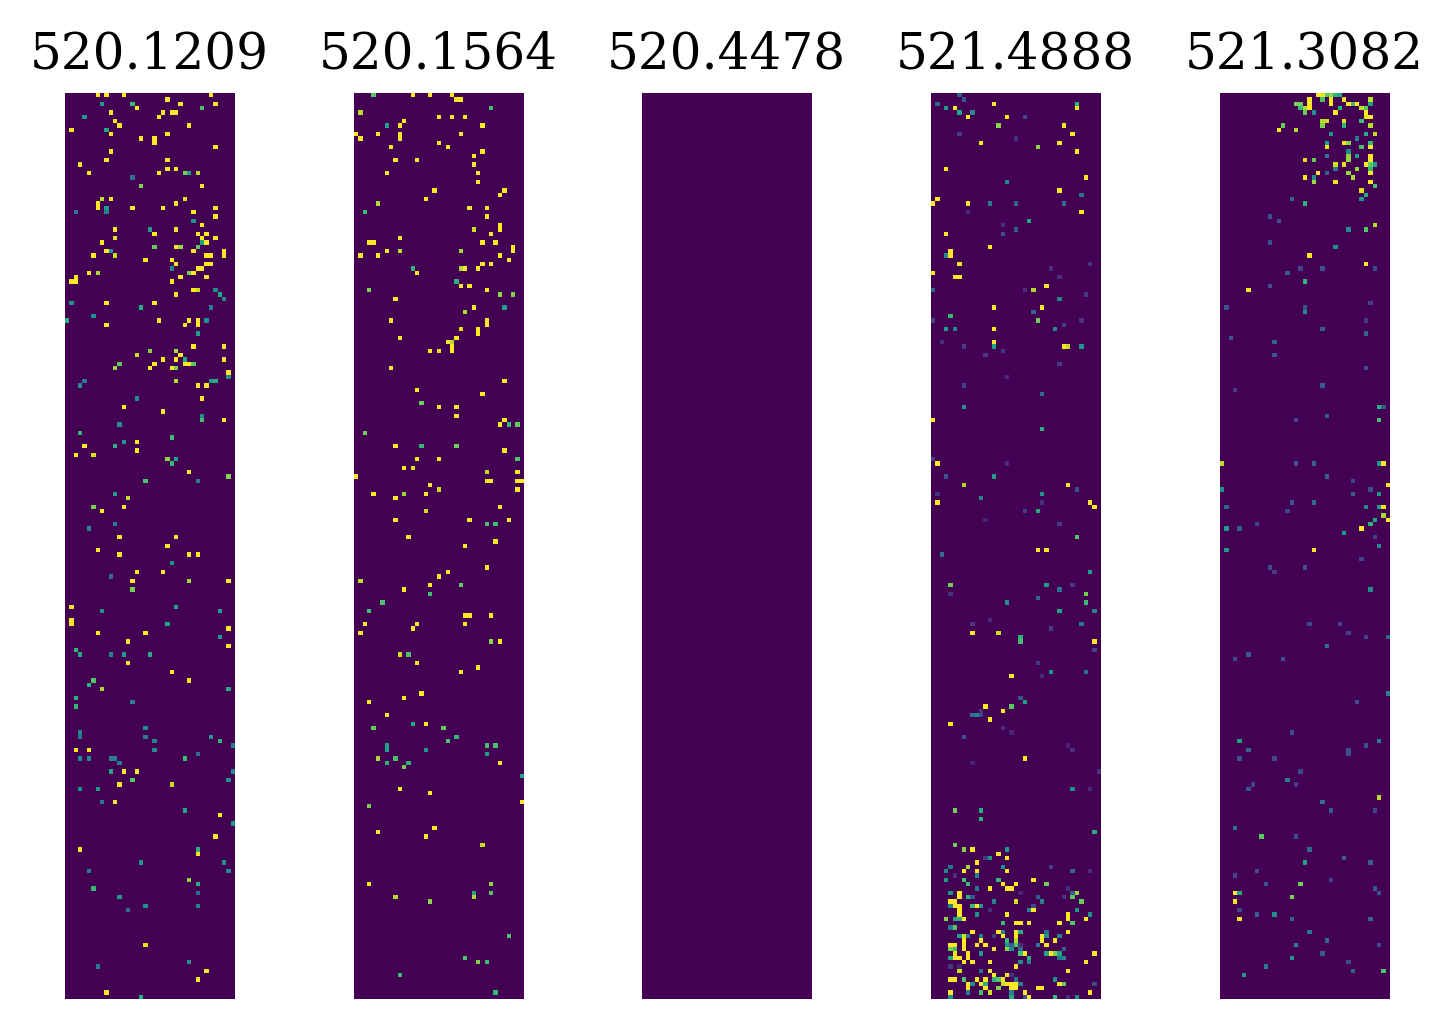

In [34]:
fig, ax = plt.subplots(1, 5)
ax_idx = 0
for i in list(t_df.values.argsort(0)[0:5:1].flatten()):
    ax[ax_idx].imshow(ims[i])
    ax[ax_idx].set_title(list(t_df.index)[i])
    ax[ax_idx].axis('off')
    ax_idx += 1
plt.show()

Here we decide 0.4 to be the appropriate cutoff score for peak picking, the value may vary in different experiments

In [35]:
feature_table, ims = sel_peak_by_rank(t_df, ims, feature_table, 0.4)

To get a relatively stable NMF result, we need to first determine the rank we want to use.

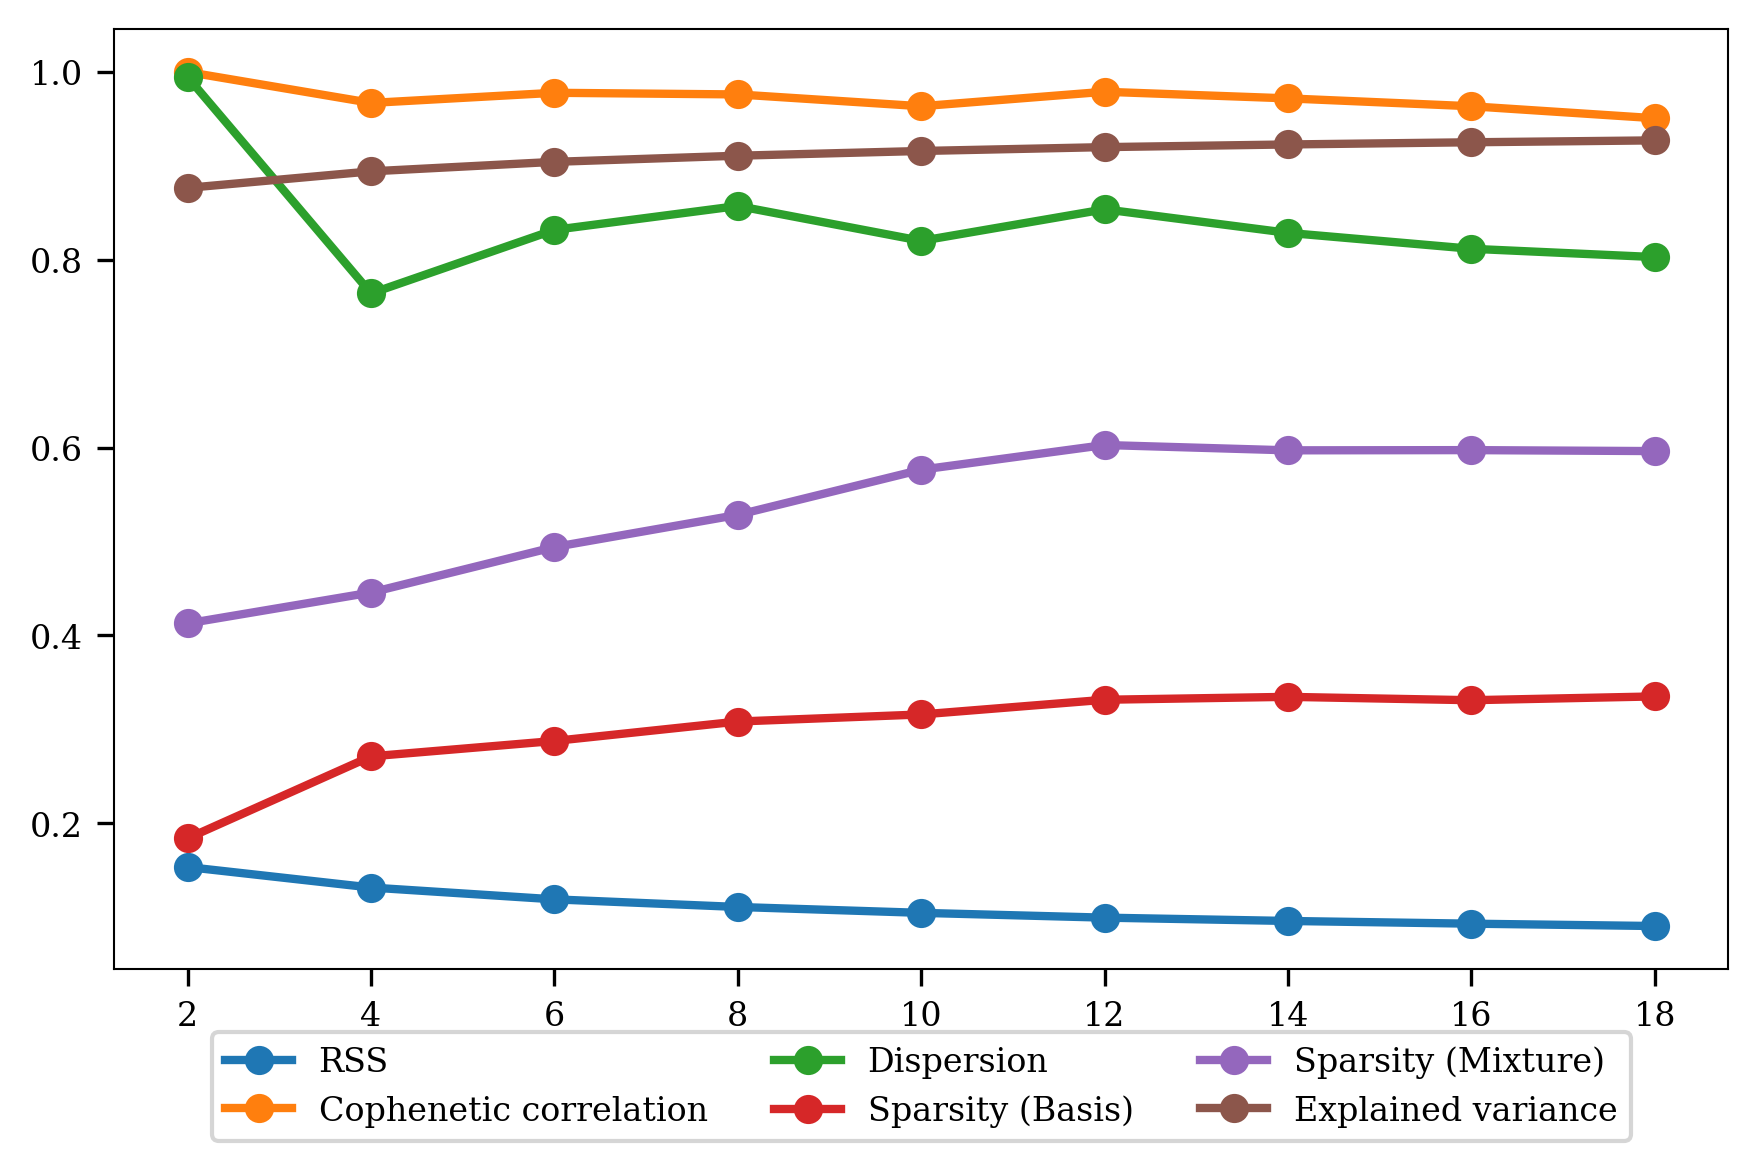

In [36]:
rank_candidates = list(range(2, 20, 2))

rank_estimate(rank_candidates, ims)

Here we choose a rank of 8, because the Cophenetic correlation peaks. The algorithm needs to be run repetitively (n_run > 1) to produce network

In [37]:
b, c, G = nmf(ims, feature_table, 8, n_run=10)

C:\Users\hlabuser\PycharmProjects\msi_feature_extraction\mfe\src\feature.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  consensus.values[[np.arange(len(consensus))] * 2] = np.nan


Here we can see what the extracted 8 features look like (basis matrix), the contribution of each ion image to each component is stored in the coefficients matrix `c`

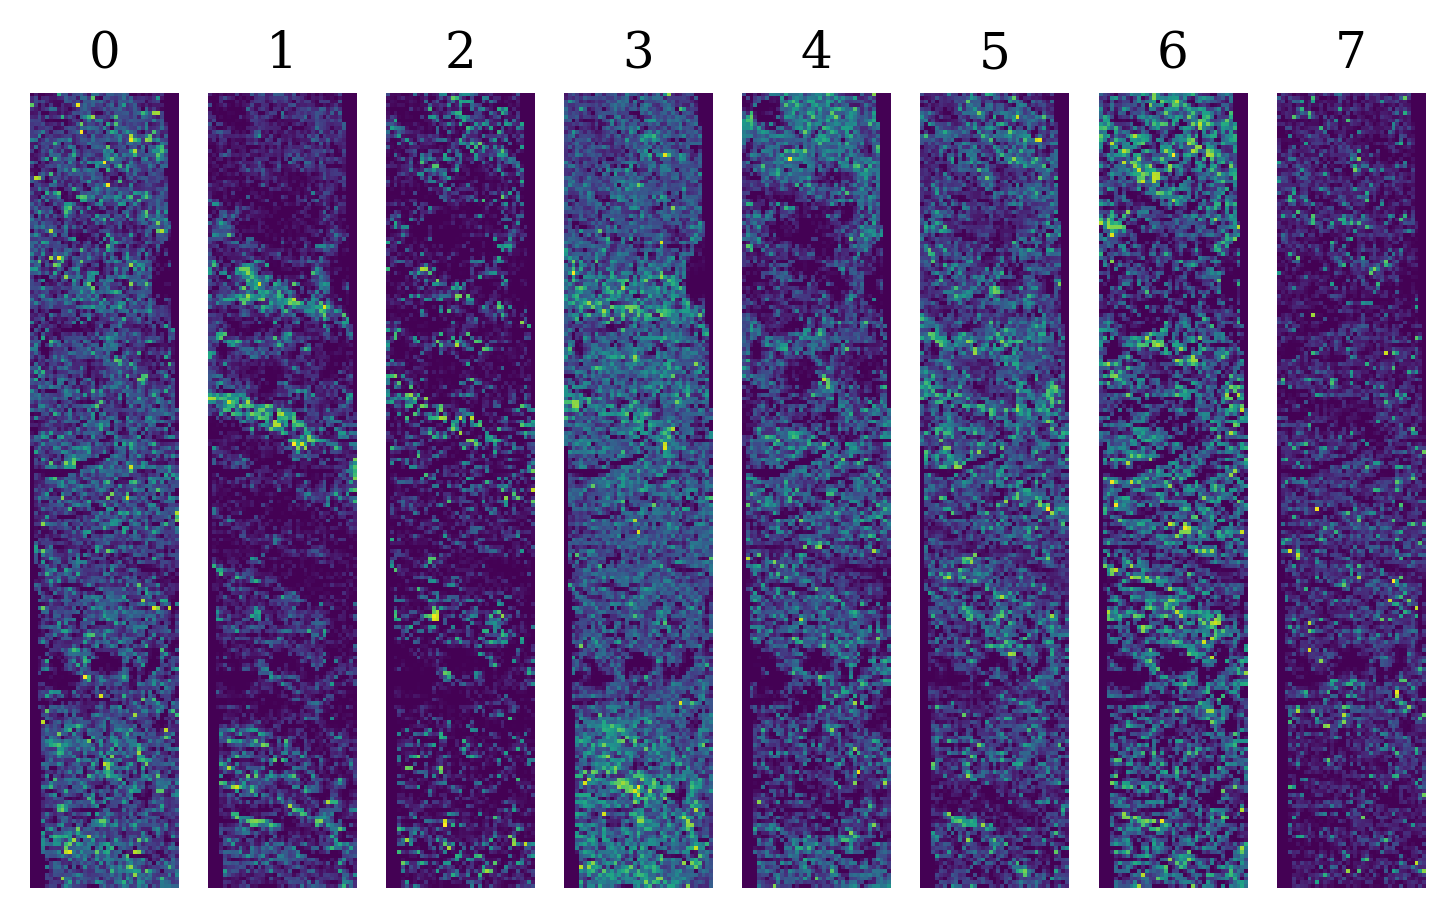

In [39]:
fig, ax = plt.subplots(1, 8)
for i in range(len(b.T)):
    ax[i].imshow(b.iloc[:,i].to_numpy().reshape(ims[0].shape))
    ax[i].set_title(f'{i}')
    ax[i].axis('off')
    ax_idx += 1
plt.show()

Have a look at what the molecular network looks like

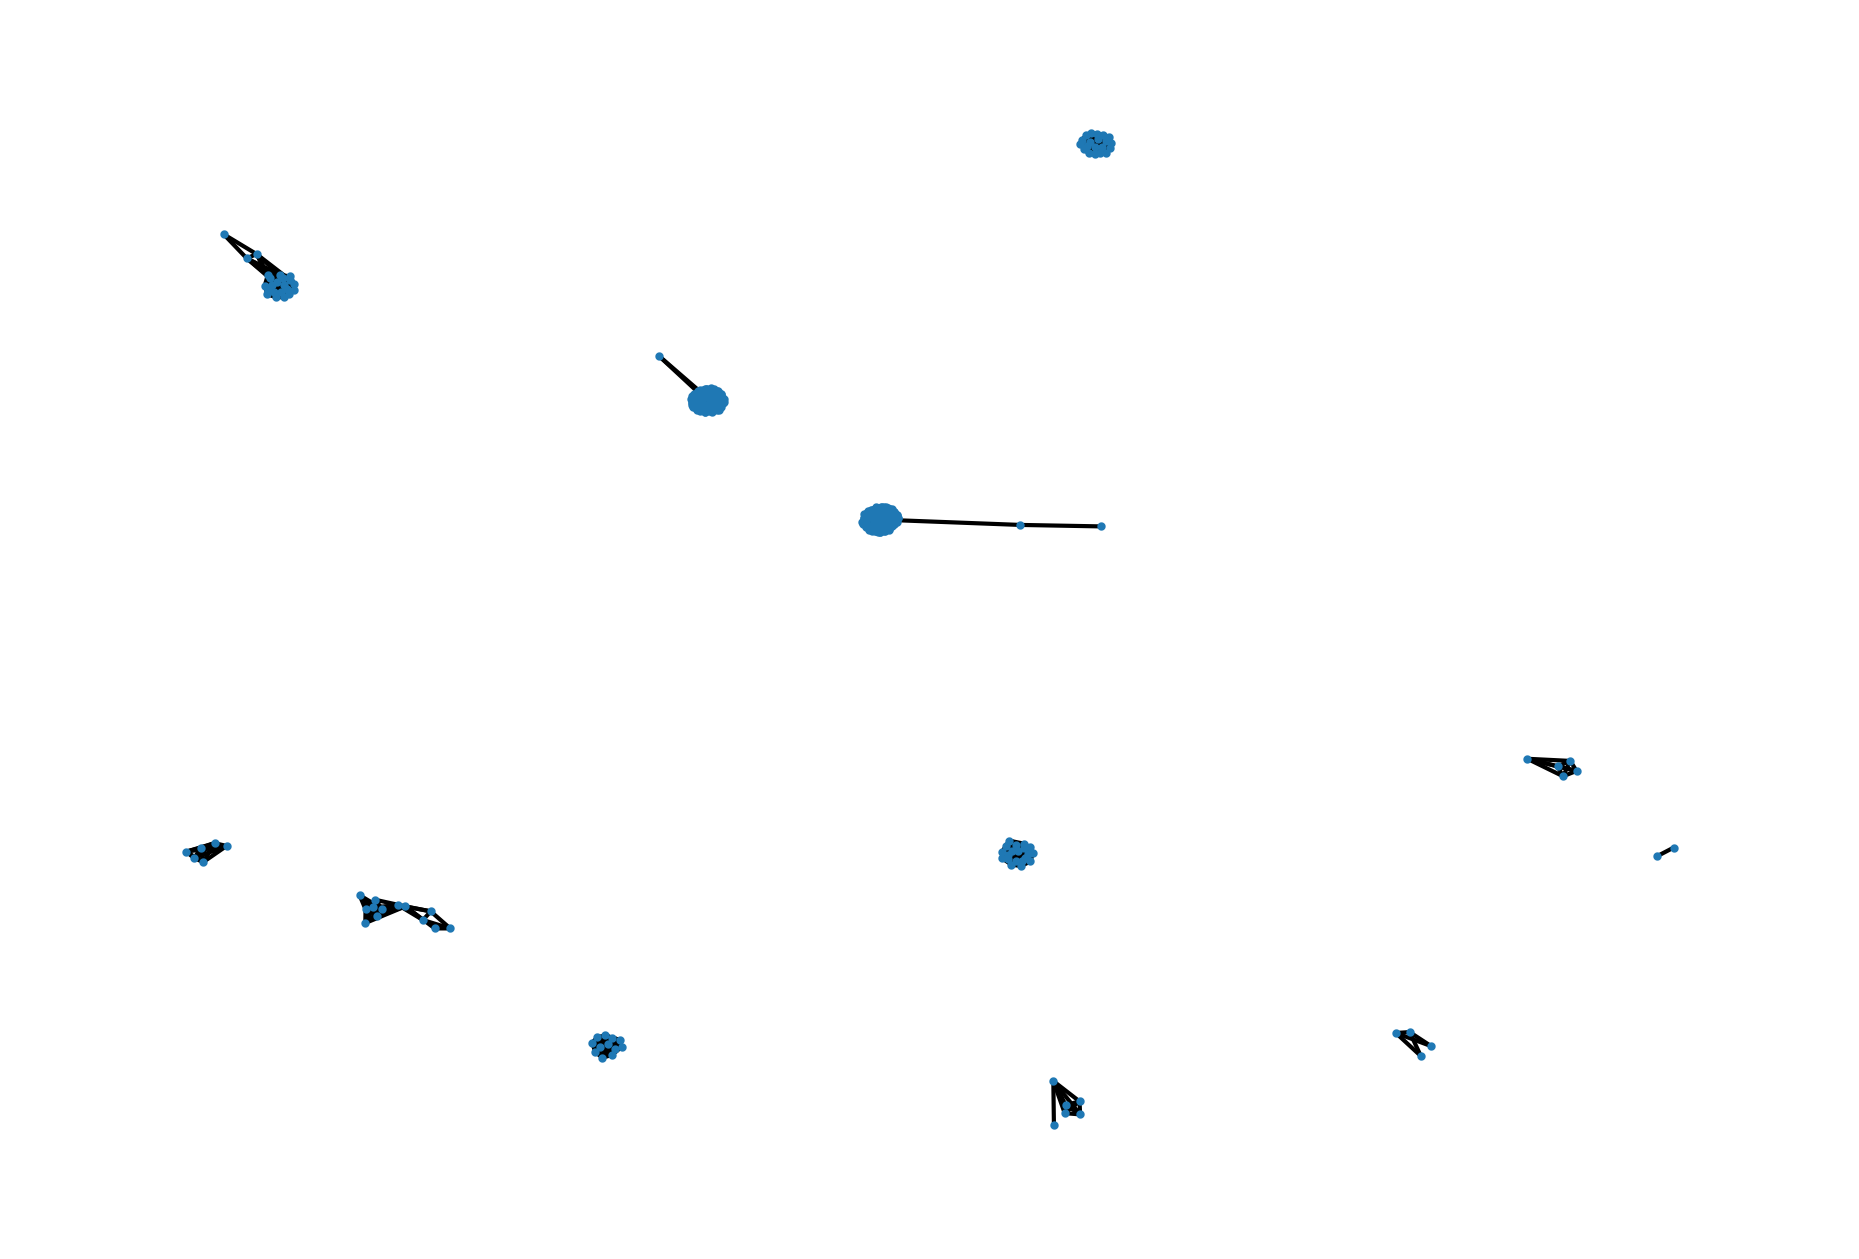

In [44]:
import networkx as nx
nx.draw(G, node_size=1, pos=nx.spring_layout(G))

Save the network for other analysis

In [48]:
nx.write_graphml(G, './SBB5-10cm_520-580_mn.graphml')